# State preparation using quantum signal processing

We are going to apply a delta function to the Hamiltonian ($H$) such that all states with eigenvalues outside a specific energy ($\lambda \pm \Delta/2$) are supressed. This is performed by applying the operation,

$f_n(x,\delta)=\frac{T_n(-1+2\frac{H^2-\Delta^2}{1-\Delta^2})}{T_n(-1+2\frac{-\Delta^2}{1-\Delta^2})}$

using quantum signal processing Where $T_n$ is the chebyshev polynomial of the first kind. The polynomial with approximation order $k=20$ for $\Delta = 0.1$ is shown below.

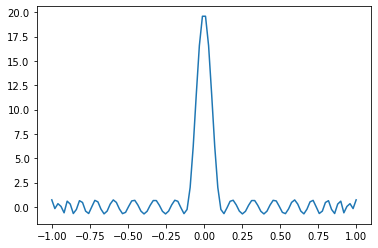

In [354]:
from scipy.special import eval_chebyt
import numpy as np
import matplotlib.pyplot as plt

k = 20
delta = 0.1

def filter_func(x, delta, k):
    val = 0
    for i in range(k):
        arg = -1 + 2*((x**2-delta**2)/(1-delta**2))
        topk = eval_chebyt(k, arg)
        arg = -1 + 2*(-delta**2/(1-delta**2))
        botk = eval_chebyt(k, arg)
        val += topk/botk
    return val

xs = np.linspace(-1, 1, 100)

ys = np.zeros(len(xs))

for i, x in enumerate(xs):
    ys[i] = filter_func(x, delta, k)

plt.plot(xs, ys)


This polynomial needs to be converted to phases to use Quantum Signal Processing. For conveinience, here are the phases for $k=20$ and $\Delta = 0.1$. At the end of the notebook, there are two ways to calculate the phases given a polynomial.

In [390]:
# phases below are calculated using QSPPACK for n=20, delta = 0.1
phases = [ 0.76974538,  0.00646461, -0.00773143,  0.00908568, -0.01051591,  0.01200849,
          -0.01354772,  0.01511600, -0.01669402,  0.01826109, -0.01979540,  0.02127448,
          -0.02267559,  0.02397626, -0.02515479,  0.02619086, -0.02706603,  0.02776435,
          -0.02827282,  0.02858185, -0.02868552,  0.02858185, -0.02827282,  0.02776435,
          -0.02706603,  0.02619086, -0.02515479,  0.02397626, -0.02267559,  0.02127448,
          -0.01979540,  0.01826109, -0.01669402,  0.01511600, -0.01354772,  0.01200849,
          -0.01051591,  0.00908568, -0.00773143,  0.00646461,  0.76974538]

## State preparation example

We are going to prepare two different states using the phases above and the Quantum Signal Processing circuit `get_qsp_circuit_no_anc` as defined in [arXiv:2002.11649](https://arxiv.org/abs/2002.11649).

We are going to apply it to H2 in a STO-3G basis with the "scbk" qubit mapping. 

In [358]:
from openfermion import get_sparse_operator
import numpy as np

from tangelo.molecule_library import mol_H2_sto3g
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
from tangelo.linq.helpers.circuits.statevector import StateVector

fe_op = mol_H2_sto3g.fermionic_hamiltonian
qu_op = fermion_to_qubit_mapping(fe_op, "scbk", n_spinorbitals=4, n_electrons=2)

ham = get_sparse_operator(qu_op).toarray()
eigs, vecs = np.linalg.eigh(ham)
alpha = eigs[3]-eigs[0]

init_state = np.random.random(4)
init_state /= np.linalg.norm(init_state)

sv = StateVector(init_state)
init_circ = sv.initializing_circuit()


### First excited state

We need to shift the Hamiltonian such that the desired eigenvalue ($\lambda$) is centered at zero and the spectral range is in [-1, 1]. This is done by

$\tilde{H} = \frac{H-\lambda}{\alpha + \left|\lambda\right|}$

where $\alpha$ is the approximation to the spectral range.

In [393]:
from tangelo.linq import Circuit, Gate, get_backend
from tangelo.toolboxes.circuits.qsp import get_qsp_circuit_no_anc
from tangelo.toolboxes.circuits.lcu import get_uprep_uselect, get_lcu_qubit_op_info

lamb = eigs[1]
# Shift Hamiltonian so that spectrum is in [-1, 1] and desired lambda is at 0
qu_op_tilde = (qu_op - lamb)/(alpha+abs(lamb))

qu_op_qs, m_qs, alpha = get_lcu_qubit_op_info(qu_op_tilde)
uprep, uselect, qu_op_qs, m_qs, alpha = get_uprep_uselect(qu_op_tilde)
cua = uprep + uselect + uprep.inverse()
eig_filt_circ = get_qsp_circuit_no_anc(cua, m_qs, phases)

# Add the mesurement gates to the ancilla qubits for the application of the Linear Combination
# of Unitaries plus the extra qubit for the QSP
# Measure gates for LCU ancilla qubits
full_circuit = init_circ + eig_filt_circ + Circuit([Gate("MEASURE", m) for m in m_qs])
# Measure gate for the QSP qubit where the phases are applied
full_circuit += Circuit([Gate("MEASURE", m_qs[-1]+1)])

In [395]:
sim = get_backend("qulacs")

f, sv = sim.simulate(full_circuit, desired_meas_result="0000", return_statevector=True)
# Pick out part of wavefunction that corresponds to "0000" on ancilla qubits
sv = np.reshape(sv, (2**4, 4))[0, :]
# Reorder statevector to correspond to openfermion ordering
sv = np.reshape(sv, (2,2)).T.flatten()

print(f'initial overlap = {abs(np.dot(vecs[:,1], init_state))}')
print(f'final overlap = {abs(np.dot(vecs[:,1], sv))}')

initial overlap = 0.5096635574715872
final overlap = 0.9987906479750979


### Second excited state

In [381]:
lamb = eigs[2]
# Shift Hamiltonian so that spectrum is in [-1, 1] and desired lambda is at 0
qu_op_tilde = (qu_op - lamb)/(alpha+abs(lamb))

qu_op_qs, m_qs, alpha = get_lcu_qubit_op_info(qu_op_tilde)
uprep, uselect, qu_op_qs, m_qs, alpha = get_uprep_uselect(qu_op_tilde)
cua = uprep + uselect + uprep.inverse()
eig_filt_circ = get_qsp_circuit_no_anc(cua, m_qs, phases)

full_circuit = init_circ + eig_filt_circ + Circuit([Gate("MEASURE", m) for m in m_qs])
full_circuit += Circuit([Gate("MEASURE", m_qs[-1]+1)])

In [383]:
sim = get_backend("qulacs")

f, sv = sim.simulate(full_circuit, desired_meas_result="0000", return_statevector=True)
# Pick out part of wavefunction that corresponds to "0000" on ancilla qubits
sv = np.reshape(sv, (2**4, 4))[0, :]
# Reorder statevector to correspond to openfermion ordering
sv = np.reshape(sv, (2,2)).T.flatten()

In [384]:
print(f'initial overlap = {abs(np.dot(vecs[:,2], init_state))}')
print(f'final overlap = {abs(np.dot(vecs[:,2], sv))}')

initial overlap = 0.8563893032170957
final overlap = 0.9997976485907082


## Code to generate phases
All code cells are changed to markdown as other packages are required to run the following phase calculations. 

#### Using QSPPACK

```python
from sympy.abc import x
from sympy import Rational
from sympy.polys.polytools import primitive
from sympy.functions.special.polynomials import chebyshevt

k = 20
# Necessary to work in exact representation for higher order polynomials
delta = Rational(delta)

def filter_func(x, delta, k):
    val = 0
    for i in range(k):
        arg = -1 + 2*((x**2-delta**2)/(1-delta**2))
        topk = chebyshevt(k, arg)
        arg = -1 + 2*(-delta**2/(1-delta**2))
        botk = chebyshevt(k, arg)
        val += topk/botk
    return val
```

Need to convert polynomial to coefficients of expansion in Chebyshev polynomials

```python
# Use chebyshev interpolation ak=2/(n+1)*sum_{j=0}^n p(x_j)T_k(x_j), x_j = cos(\frac{2*j+1}{2*n+2}\pi)
poly = filter_func(x, delta, k).as_poly()

n = 2*k
xjs = np.zeros(n+1)
aks = np.zeros(n+1)
for j in range(n+1):
    xjs[j] = np.cos((2*j+1)/(2*n+2)*np.pi)

for ki in range(0, n+1, 2):
    aks[ki] = 0
    for j in range(n+1):
        aks[ki] += 2/(n+1)*poly.eval(xjs[j])*eval_chebyt(ki, xjs[j])

aks /= k*np.sqrt(2)
aks[0] /=2
aks = aks[0: n+1: 2]
```

Use `oct2py` (with octave installed) and the folder location of `QSPPACK` cloned from https://github.com/qsppack/QSPPACK. 

```python
from oct2py import octave
eps = 0.01
folder = 'path to QSPPACK'
octave.addpath(folder)
opts = octave.struct("criteria", eps)
phases, _ = octave.QSP_solver(aks, 0, opts, nout=2)
```

#### Using pyqsp

For $k=20$ pyqsp with `laurent` works properly. However, it often fails for higher order polynomials. In that case, you will need to install tensorflow and use the method=`tf` which is much slower than `QSPPACK`. 

```python
import pyqsp
from pyqsp import angle_sequence
from pyqsp.angle_sequence import AngleFindingError
from pyqsp.completion import CompletionError

# Compute phases for real part Cos(Ht) of Exp(iHt)
pg = pyqsp.poly.PolyCosineTX()
prefac, poly = primitive(filter_func(x, delta, k))
poly = poly.as_poly()
polydict = poly.as_dict()

coefs = np.zeros(2*k + 1, dtype=float)
for term, coeff in polydict.items():
    coefs[term[0]] = prefac*coeff/k/np.sqrt(2)

n_attempts = 100
method = 'laurent'
eps=0.01
for i in range(n_attempts):
        try:
            phases = angle_sequence.QuantumSignalProcessingPhases(
                coefs, eps=eps, suc=1-eps/10, method=method, tolerance=0.01)
        except (AngleFindingError, CompletionError):
            if i == n_attempts-1:
                raise RuntimeError("Real phases calculation failed, increase n_attempts or eps")
            else:
                print(f"Attempt {i+2} for the real coefficients")
        else:
            break
```